### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Zimo Peng`

**Student ID:**     `1143743`


This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [1]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

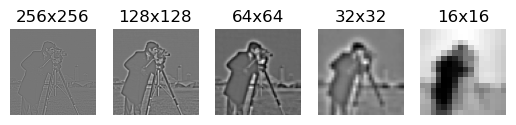

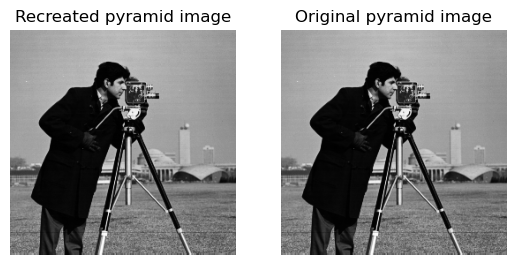

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])

org_img = cv2.imread(os.path.join('./', "cameraman.png"),cv2.IMREAD_GRAYSCALE)

def do_laplacian(n, org_img, kernel):
    layers = dict()
    size = 0
    for i in range(n):
        if (i < n - 1):
            ##filter the orginal image with the given kernel
            filtered = cv2.filter2D(src = org_img, ddepth = -1, kernel = kernel)
            ##downsample all the values of the filtered image by removing every 2nd column and row
            down = filtered[::2, ::2]
            ##upsample the values of the filtered image by first making all values 0
            up = np.zeros((filtered.shape[0], filtered.shape[1]))
            ##insert in every second column and row, the corresponding downsampled pixel
            up[::2, ::2] = down
            up = up.astype(np.float64)
            ##filter this upsampled image through the new kernel
            filtered_u = cv2.filter2D(up, -1, kernel*4)
            ##subtract the filtered upsampled image from the original image and store it in layers
            layers[size] = cv2.subtract(org_img, filtered_u, dtype=cv2.CV_16S)
            size += 1   
            ##original image becomes the downsampled image
            org_img = down
        else:
            ##the last layer will be the last downsampled image
            layers[size] = org_img
    return layers

def recreation(layers):
    size = len(layers)
    img = layers[size-1]
    for i in range(size-1)[::-1]:
        ##upsampling the image using the same method as before
        up = np.zeros((layers[i].shape[0], layers[i].shape[1]))
        up[::2, ::2] = img
        up = up.astype(np.float64)
        filtered_u = cv2.filter2D(src = up, ddepth = -1, kernel = 4*kernel)
        ##new image is made by adding the upsampled image back to the layer
        img = filtered_u + layers[i]
    return img  

num_layers = 5
layers = do_laplacian(num_layers, org_img, kernel)
img_old = recreation(layers)

##creation of plots
for idx in range(num_layers+1)[1:]:
    plt.subplot(1,num_layers,idx)
    plt.imshow(layers[idx-1], cmap = 'gray')
    plt.title(str((layers[idx-1].shape)[0])+"x"+str((layers[idx-1].shape)[1]))
    plt.axis('off')
plt.show()

plt.subplot(1,2,1)
plt.imshow(img_old, cmap = 'gray')
plt.title("Recreated pyramid image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(org_img, cmap = 'gray')
plt.title("Original pyramid image")
plt.axis('off')

plt.show()


### 2. Quantization and compression

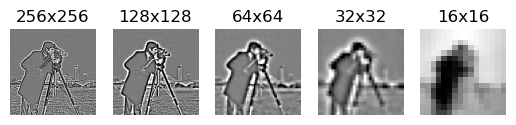

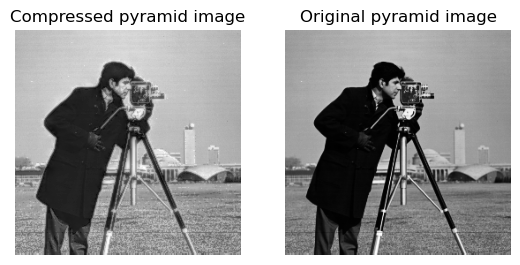

In [7]:
import math
def quantization(layer, bits):
    picture = layer
    picture = picture.astype(np.float64)
    total_bins = 2**bits
    height = layer.shape[0]
    width = layer.shape[1]
    # if there are more bins than pixels, then there are too many bins
    if total_bins > (height*width):
        print("too many bins")
        return
    ##flatten the image array into a 1D array
    layer = layer.ravel()
    layer = layer.astype(np.float64)
    ##sort the array in ascending order
    sorted_layer = np.sort(layer)
    ##separate the flattened array into the specified amount of bins, with an equal number of pixels in each bin
    layer = sorted_layer.reshape(total_bins, -1)
    ##each bin has its minimum and maximum value
    bins = [(x[0], x[-1]) for x in layer] 
    ##dictionary where each key is the bin, and the value is the average of that bin
    avg_dicts = {binn: (sorted_layer[(sorted_layer>=binn[0]) & (sorted_layer <= binn[1])]).mean() for binn in bins}
    ##for every pixel in the array, the pixel is assigned the mean of the bin it belongs to.
    new_picture = np.array([put_bins(avg_dicts, row) for row in picture])
    return (new_picture)
     
##this function takes all the bins and the current row, and assigns each pixel a mean corresponding to its assigned bin
def put_bins(bins,row):
    size = 0
    for value in row:
        for binn in bins.keys():
            if ((value >= binn[0]) and (value <= binn[1])):
                row[size] = bins[binn]
                break
        size += 1
    return row

bits = [3,4,5,5]
new_layers = dict()
for idx in range(len(bits)):
    new_layers[idx] = quantization(layers[idx], bits[idx])
new_layers[len(bits)] = layers[len(bits)] = layers[len(bits)]
##recreation of the image with the new layers
img = recreation(new_layers)

for idx in range(num_layers+1)[1:]:
    plt.subplot(1,num_layers,idx)
    plt.imshow(new_layers[idx-1], cmap = 'gray')
    plt.title(str((new_layers[idx-1].shape)[0])+"x"+str((new_layers[idx-1].shape)[1]))
    plt.axis('off')
plt.show()

plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Compressed pyramid image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(org_img, cmap = 'gray')
plt.title("Original pyramid image")
plt.axis('off')

plt.show()

### 3. Evaluation in the frequency domain